## Library

In [1]:
import os
import glob
import numpy as np
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.wcs import WCS
from astropy.io import fits
from astropy import units as u
import string
from astropy.visualization.stretch import LinearStretch
from astropy.visualization import ZScaleInterval

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams["savefig.dpi"] = 500
mpl.rcParams["xtick.labelsize"] = 14  # X축 틱의 글자 크기 설정
mpl.rcParams["ytick.labelsize"] = 14  # Y축 틱의 글자 크기 설정
plt.rc("font", family="serif")

## Function

In [3]:
def makeSpecColors(n, palette='Spectral'):
	#	Color palette
	import seaborn as sns
	palette = sns.color_palette(palette, as_cmap=True,)
	palette.reversed

	clist_ = [palette(i) for i in range(palette.N)]
	cstep = int(len(clist_)/n)
	clist = [clist_[i*cstep] for i in range(n)]
	return clist

In [4]:
wavelengths= np.arange(4000, 8875+125, 125)

wfilters = ['m375w', 'm425w']

mfilters = [f"m{str(center_lam)[0:3]}" for center_lam in wavelengths]
mcolors = np.array(makeSpecColors(len(mfilters)))[::-1]
mlamarr = np.array([float(filte[1:]) for filte in mfilters])

bfilters = ['u', 'g', 'r', 'i', 'z']
blamarr = [3543./10, 4770./10, 6231./10, 7625./10, 9134./10]

filter_color_palette_dict = {
	'u': 'blue',
	'g': 'green',
	'r': 'tomato',
	'i': 'crimson',
	'z': 'purple',
	'm375w': 'cyan',
	'm425w': 'dodgerblue',
}

filters = mfilters+bfilters+wfilters

for filte, c in zip(mfilters, mcolors):
	filter_color_palette_dict[filte] = c

In [5]:
alphabet_string = string.ascii_uppercase
alphabet_string[:20]

'ABCDEFGHIJKLMNOPQRST'

In [6]:
filter_dict = {}
for filte, alphabet in zip(mfilters, mlamarr):
	filter_dict[filte] = alphabet


In [7]:
plot_dict = {}
for filte, alphabet in zip(mfilters[::2], alphabet_string[:20]):
	plot_dict[filte] = alphabet

In [8]:
path_data = '/large_data/processed_1x1_gain2750'
# path_data = '/large_data/Commission'
path_save = '/large_data/Commission'

In [9]:
N = 25  # Snapshot 크기
# N = 200  # Snapshot 크기
sep_limit = 5. # [arcsec]

# Input

In [10]:
# field = 'COSMOS_1'
# ra, dec = 149.3355439, 1.9185521 # [deg]

# field = 'NGC1097'
# ra, dec = 41.5412662, -30.2280701 # [deg]

# field = 'NGC3511'
# ra, dec = 165.9422083, -23.2456889 # [deg]

field = 'AT2024ufz'
ra, dec = 230.854146154, -37.3767253846 # [deg]

# obj = 'test'
obj = field
c_target = SkyCoord(ra, dec, unit='deg')

In [11]:
# path_input = f"{path_data}/COSMOS"
path_input = f"{path_data}/{field}"

In [12]:
# images = sorted(glob.glob(f"{path_input}/calib*{field}*_m???_*.com.fits"))
# images = sorted(glob.glob(f"{path_input}/*/calib*{field}*_m???_*.com.fits"))
images = sorted(glob.glob(f"{path_input}/*/*/calib*{field}*_m???_*.com.fits"))
print(f"{len(images)} images found")

18 images found


In [13]:
image_dict = {}
for inim in images:
	# photcat = inim.replace('fits', 'phot.cat')
	photcat = inim.replace('fits', 'phot.cat').replace('/calib', '/phot/calib')
	if os.path.exists(photcat):
		image_dict[inim] = photcat
	else:
		image_dict[inim] = None

image_dict

{'/large_data/processed_1x1_gain2750/AT2024ufz/7DT02/m450/calib_7DT02_AT2024ufz_20240903_004447_m450_300.com.fits': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT02/m450/phot/calib_7DT02_AT2024ufz_20240903_004447_m450_300.com.phot.cat',
 '/large_data/processed_1x1_gain2750/AT2024ufz/7DT02/m475/calib_7DT02_AT2024ufz_20240903_005154_m475_300.com.fits': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT02/m475/phot/calib_7DT02_AT2024ufz_20240903_005154_m475_300.com.phot.cat',
 '/large_data/processed_1x1_gain2750/AT2024ufz/7DT03/m500/calib_7DT03_AT2024ufz_20240903_004447_m500_300.com.fits': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT03/m500/phot/calib_7DT03_AT2024ufz_20240903_004447_m500_300.com.phot.cat',
 '/large_data/processed_1x1_gain2750/AT2024ufz/7DT03/m525/calib_7DT03_AT2024ufz_20240903_005150_m525_300.com.fits': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT03/m525/phot/calib_7DT03_AT2024ufz_20240903_005150_m525_300.com.phot.cat',
 '/large_data/processed_1x1_gain2750/AT2

# Main

In [68]:
# 1. 이미지 데이터 로드 및 WCS 설정
image_file = images[5]
cat_file = image_dict[image_file]
filte = os.path.basename(image_file).split('_')[-2]
color = filter_color_palette_dict[filte]

magkey = f"MAG_AUTO_{filte}"
magerrkey = f"MAGERR_AUTO_{filte}"
depthkey = f'UL5_1'

intbl = Table.read(cat_file, format='ascii')
c_cat = SkyCoord(intbl['ALPHA_J2000'], intbl['DELTA_J2000'], unit='deg')

hdul = fits.open(image_file)
image_data = hdul[0].data
wcs = WCS(hdul[0].header)
hdul.close()

In [69]:
# 3. 특정 좌표 (RA, DEC)에 대해 NxN 스냅샷을 추출
def extract_snapshot(ra, dec, N):
    # 해당 좌표를 픽셀 좌표로 변환
    x, y = wcs.all_world2pix(ra, dec, 0)

    # 중심 픽셀 좌표를 기준으로 NxN 영역 추출
    x_min = int(x - N//2)
    x_max = int(x + N//2)
    y_min = int(y - N//2)
    y_max = int(y + N//2)

    data = image_data[y_min:y_max, x_min:x_max]
    data[np.isnan(data)] = 0.0

    #	Sci
    data[np.isnan(data)] = 0.0
    transform = LinearStretch()+ZScaleInterval()
    snapshot = transform(data)

    return snapshot

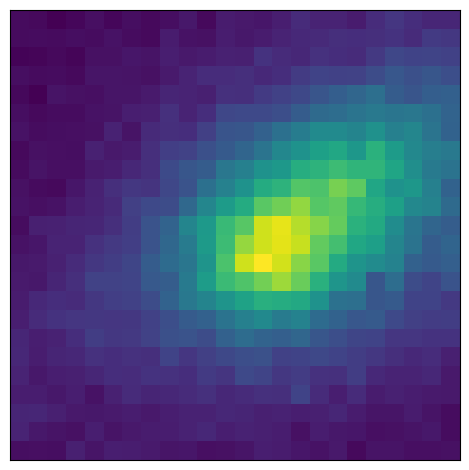

In [70]:
snapshot = extract_snapshot(ra, dec, N)
plt.imshow(snapshot, vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

Text(0.5, 1.0, 'Diff')

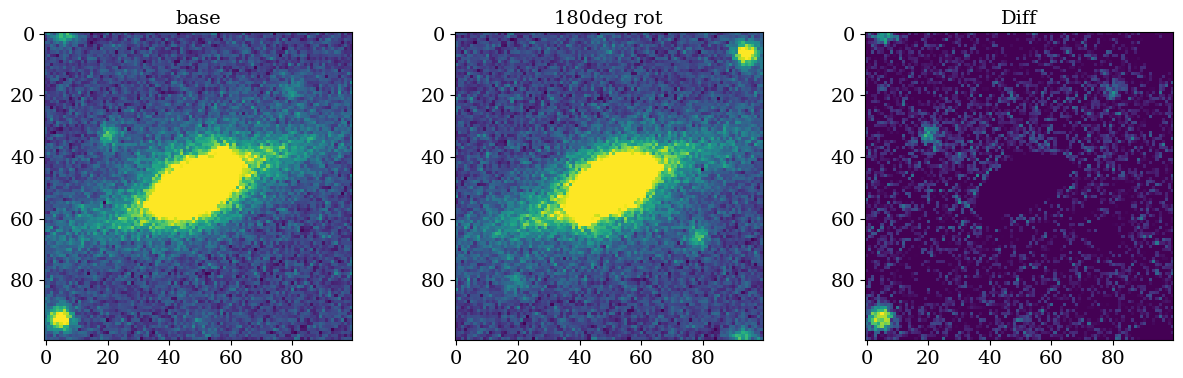

In [71]:

#	Default ra dec
# c = SkyCoord("15 23 24.788 -37 22 38.10", unit=(u.hourangle, u.deg))

#
c = SkyCoord("15 23 24.70 -37 22 36.90", unit=(u.hourangle, u.deg))

data = extract_snapshot(c.ra.deg, c.dec.deg, N=100)
rot_data = np.rot90(data, 2)
dif_data = data - rot_data

fig = plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(data, vmin=0)
plt.title('base')
plt.subplot(132)
plt.imshow(rot_data, vmin=0)
plt.title('180deg rot')
plt.subplot(133)
plt.imshow(dif_data, vmin=0)
plt.title('Diff')


In [41]:
indx, sep, _ = c_target.match_to_catalog_sky(c_cat)
depth = hdul[0].header[depthkey]

if (sep.arcsec < sep_limit)[0]:
	mag = intbl[magkey][indx]
	magerr = intbl[magerrkey][indx]
else:
	mag = -99.
	magerr = -99.

In [42]:

mosaic = f"""
{alphabet_string[:20]}
{"Z"*20}
{"Z"*20}
"""


In [43]:
# fig, ax = plt.subplot_mosaic(
# 	mosaic, figsize = (38, 6),
# 	empty_sentinel = "x",
# 	gridspec_kw = dict(
# 		# width_ratios=[1, 2, 2], height_ratios=[1, 2],
# 		wspace = 0.1, hspace = 0.1,
# 		)
# 	)

# ax["A"].imshow(snapshot, vmin=0)

# ax["Z"].errorbar(mlamarr[0], mag, yerr=magerr, marker='s', color=color)

# plt.xlim(387.5, 887.5)

## All

In [44]:
line_width = 5

In [45]:
filter_image_dict = {}
for filte in mfilters[::2]:
	filter_image_dict[filte] = None
	for image in images:
		if filte in image:
			filter_image_dict[filte] = image
filter_image_dict

{'m400': None,
 'm425': None,
 'm450': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT02/m450/calib_7DT02_AT2024ufz_20240903_004447_m450_300.com.fits',
 'm475': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT02/m475/calib_7DT02_AT2024ufz_20240903_005154_m475_300.com.fits',
 'm500': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT03/m500/calib_7DT03_AT2024ufz_20240903_004447_m500_300.com.fits',
 'm525': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT03/m525/calib_7DT03_AT2024ufz_20240903_005150_m525_300.com.fits',
 'm550': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT05/m550/calib_7DT05_AT2024ufz_20240903_004447_m550_300.com.fits',
 'm575': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT05/m575/calib_7DT05_AT2024ufz_20240903_005150_m575_300.com.fits',
 'm600': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT06/m600/calib_7DT06_AT2024ufz_20240903_004503_m600_300.com.fits',
 'm625': '/large_data/processed_1x1_gain2750/AT2024ufz/7DT06/m625/calib_7DT06_AT2024ufz_20240903_00522

In [46]:

# mosaic = f"""
# {alphabet_string[:20]}
# {"Z"*20}
# {"Z"*20}
# """



mosaic = f"""
{alphabet_string[:10]}
{alphabet_string[10:20]}
{"Z"*10}
{"Z"*10}
"""


In [47]:
# vmax = None
vmax = 1

/tmp/ipykernel_3714126/4288833160.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


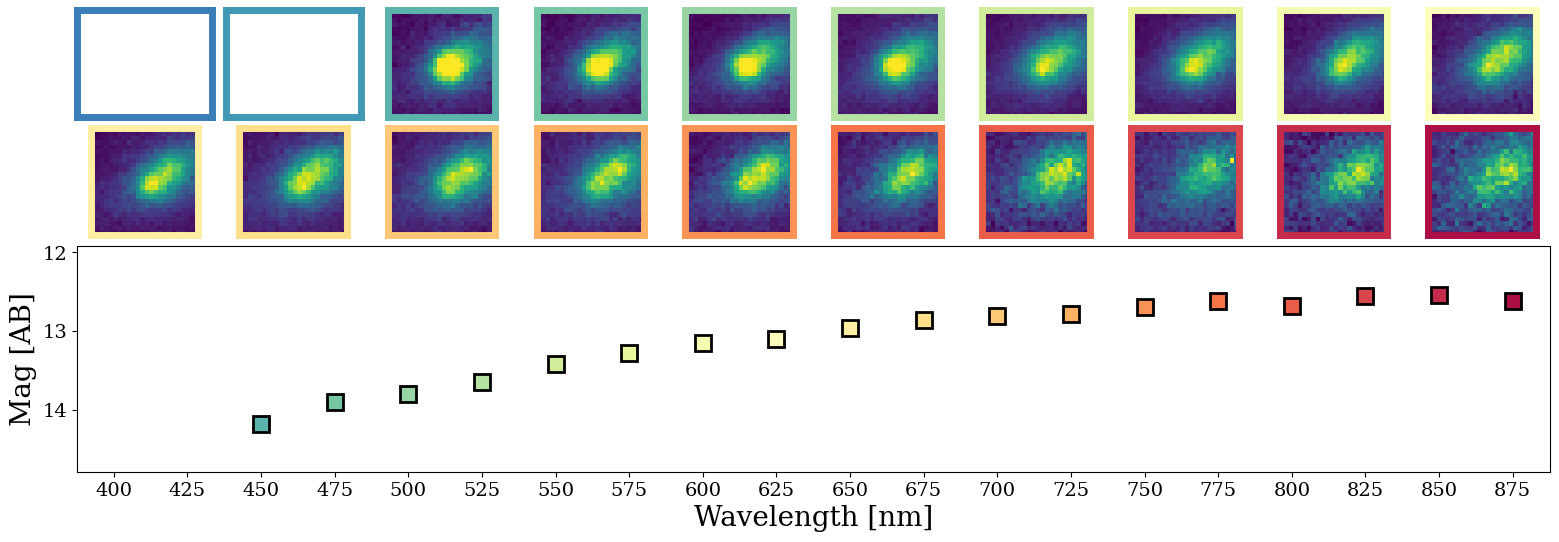

In [48]:

fig, ax = plt.subplot_mosaic(
	# mosaic, figsize = (38, 6),
	mosaic, figsize = (19, 6),
	empty_sentinel = "x",
	gridspec_kw = dict(
		# width_ratios=[1, 2, 2], height_ratios=[1, 2],
		wspace = 0.1, hspace = 0.1,
		)
	)

filled_alphabets = []

# for ii, image_file in enumerate(images):
# for ii, image_file in enumerate(filter_image_dict):
for filte, image_file in filter_image_dict.items():

	alphabet = plot_dict[filte]
	filled_alphabets.append(alphabet)
	color = filter_color_palette_dict[filte]

	if image_file != None:
		# 1. 이미지 데이터 로드 및 WCS 설정
		# image_file = images[0]
		cat_file = image_dict[image_file]
		# filte = os.path.basename(image_file).split('_')[-2]

		magkey = f"MAG_AUTO_{filte}"
		magerrkey = f"MAGERR_AUTO_{filte}"
		depthkey = f'UL5_1'

		intbl = Table.read(cat_file, format='ascii')
		c_cat = SkyCoord(intbl['ALPHA_J2000'], intbl['DELTA_J2000'], unit='deg')

		hdul = fits.open(image_file)
		image_data = hdul[0].data
		wcs = WCS(hdul[0].header)
		hdul.close()

		snapshot = extract_snapshot(ra, dec, N)

		indx, sep, _ = c_target.match_to_catalog_sky(c_cat)
		depth = hdul[0].header[depthkey]

		if (sep.arcsec < sep_limit)[0]:
			mag = intbl[magkey][indx]
			magerr = intbl[magerrkey][indx]
		else:
			mag = -99.
			magerr = -99.

		if vmax != None:
			ax[alphabet].imshow(snapshot, vmin=0, vmax=vmax)
		else:
			ax[alphabet].imshow(snapshot, vmin=0,)
		# ax[alphabet].

		if mag != -99.:
			ax["Z"].errorbar(filter_dict[filte], mag, yerr=magerr, marker='s', color=color, ms=12, mec='k', mew=2)

	#
	ax[alphabet].spines['top'].set_color(color)
	ax[alphabet].spines['bottom'].set_color(color)
	ax[alphabet].spines['left'].set_color(color)
	ax[alphabet].spines['right'].set_color(color)

	ax[alphabet].spines['top'].set_linewidth(line_width)
	ax[alphabet].spines['bottom'].set_linewidth(line_width)
	ax[alphabet].spines['left'].set_linewidth(line_width)
	ax[alphabet].spines['right'].set_linewidth(line_width)

	ax[alphabet].set_xticks([])
	ax[alphabet].set_yticks([])

for alphabet in alphabet_string[:20]:
	if alphabet not in filled_alphabets:
		snapshot = np.zeros_like(snapshot)
		ax[alphabet].imshow(snapshot, vmin=0)

		ax[alphabet].spines['top'].set_color(color)
		ax[alphabet].spines['bottom'].set_color(color)
		ax[alphabet].spines['left'].set_color(color)
		ax[alphabet].spines['right'].set_color(color)

		ax[alphabet].spines['top'].set_linewidth(line_width)
		ax[alphabet].spines['bottom'].set_linewidth(line_width)
		ax[alphabet].spines['left'].set_linewidth(line_width)
		ax[alphabet].spines['right'].set_linewidth(line_width)

		ax[alphabet].set_xticks([])
		ax[alphabet].set_yticks([])

ax["Z"].set_xticks(np.arange(350, 900+25, 25))
ax["Z"].set_xlim(387.5, 887.5)
yl, yu = ax["Z"].set_ylim()
ax["Z"].set_ylim([yu+0.5, yl-0.5])
ax["Z"].set_xlabel("Wavelength [nm]")
ax["Z"].set_ylabel("Mag [AB]")

plt.tight_layout()